In [1]:
import numpy as np
import pandas as pd

import torch

In [31]:
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
import sys

In [3]:
from copy import deepcopy

In [4]:
sys.path.append('../')
sys.path.append('../../')

In [5]:
from dltranz.util import init_logger, get_conf
from dltranz.models import model_by_type
from retail_embeddings_projects.embedding_tools.inference_tools import score_part_of_data

Can not import Transformers
../../retail_embeddings_projects/embedding_tools/inference_tools.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
from sber_finetuning import read_consumer_data, create_ds, run_experiment, load_model

In [7]:
train_target = pd.read_csv('/data/kireev-ia/data_open_ds/age-prediction-nti-sbebank-2019/data/train_target.csv')
train_target.head(5)

,client_id,bins
0,24662,2
1,1046,0
2,34089,2
3,34848,1
4,47076,3


In [8]:
init_logger(__name__)
init_logger('sber_finetuning')
init_logger('dltranz')
init_logger('retail_embeddings_projects.embedding_tools')

In [13]:
args = [
    'data_path=""',
    'output.path="pca_vectors_ft"',
    'params.pretrained_model_path="../models/sber_ml_model.p"',
    '--conf',
    '../conf/sber_target_dataset.hocon',
    '../conf/sber_targetft_params_train.json',
]
conf = get_conf(args)

2019-12-25 13:41:51,893 INFO    dltranz.util           : args: Namespace(conf=['../conf/sber_target_dataset.hocon', '../conf/sber_targetft_params_train.json']), overrides: ['data_path=""', 'output.path="pca_vectors_ft"', 'params.pretrained_model_path="../models/sber_ml_model.p"']
2019-12-25 13:41:51,899 INFO    dltranz.util           : Load config from "../conf/sber_target_dataset.hocon"
2019-12-25 13:41:51,917 INFO    dltranz.util           : Load config from "../conf/sber_targetft_params_train.json"


In [14]:
model_f = load_model

In [15]:
train_data, valid_data = read_consumer_data(conf)

2019-12-25 13:41:52,273 INFO    sber_finetuning        : Data loading...
2019-12-25 13:41:53,917 INFO    sber_finetuning        : Loaded train: 18000, valid: 12000


# Train model

In [16]:
train_ds, valid_ds = create_ds(train_data, valid_data, conf)
model, result = run_experiment(train_ds, valid_ds, conf['params'], model_f)


Epoch: 1,  accuracy: 0.552



Epoch: 2,  accuracy: 0.580



Epoch: 3,  accuracy: 0.592



Epoch: 4,  accuracy: 0.597



Epoch: 5,  accuracy: 0.598



Epoch: 6,  accuracy: 0.602



Epoch: 7,  accuracy: 0.609



Epoch: 8,  accuracy: 0.613



Epoch: 9,  accuracy: 0.603



Epoch: 10,  accuracy: 0.602



Epoch: 11,  accuracy: 0.611



Epoch: 12,  accuracy: 0.616



Epoch: 13,  accuracy: 0.618



Epoch: 14,  accuracy: 0.621



Epoch: 15,  accuracy: 0.614



Epoch: 16,  accuracy: 0.621



Epoch: 17,  accuracy: 0.621



Epoch: 18,  accuracy: 0.621



Epoch: 19,  accuracy: 0.619



Epoch: 20,  accuracy: 0.621



Epoch: 21,  accuracy: 0.625



Epoch: 22,  accuracy: 0.624



Epoch: 23,  accuracy: 0.624



Epoch: 24,  accuracy: 0.624



Epoch: 25,  accuracy: 0.623



Epoch: 26,  accuracy: 0.623



Epoch: 27,  accuracy: 0.623



Epoch: 28,  accuracy: 0.622



Epoch: 29,  accuracy: 0.624



Epoch: 30,  accuracy: 0.625



Epoch: 31,  accuracy: 0.625



Epoch: 32,  accuracy: 0.624



Epoch: 33,  accuracy: 0.625



Epoch: 34,  accuracy: 0.625



Epoch: 35,  accuracy: 0.625


# Get vectors from model

In [84]:
ix_scores = np.random.choice(np.arange(len(valid_data)), 10000, replace=False)
score_data_orig = [rec for i, rec in enumerate(valid_data) if i in ix_scores]
len(score_data_orig)

10000

In [85]:
model

Sequential(
  (0): Sequential(
    (0): TrxEncoder(
      (embeddings): ModuleDict(
        (trans_date): NoisyEmbedding(
          800, 16, padding_idx=0
          (dropout): Dropout(p=0)
        )
        (small_group): NoisyEmbedding(
          250, 16, padding_idx=0
          (dropout): Dropout(p=0)
        )
      )
    )
    (1): RnnEncoder(
      (rnn): GRU(33, 196, batch_first=True)
    )
    (2): LastStepEncoder()
  )
  (1): Linear(in_features=196, out_features=4, bias=True)
  (2): LogSoftmax()
)

In [86]:
score_model = model[0]
score_model

Sequential(
  (0): TrxEncoder(
    (embeddings): ModuleDict(
      (trans_date): NoisyEmbedding(
        800, 16, padding_idx=0
        (dropout): Dropout(p=0)
      )
      (small_group): NoisyEmbedding(
        250, 16, padding_idx=0
        (dropout): Dropout(p=0)
      )
    )
  )
  (1): RnnEncoder(
    (rnn): GRU(33, 196, batch_first=True)
  )
  (2): LastStepEncoder()
)

In [87]:
def split_trx(seq):
    def split(rec, pos_s, pos_e):
        rec = deepcopy(rec)
        rec['feature_arrays'] = {k: v[pos_s:pos_e] for k, v in rec['feature_arrays'].items()}
        rec['event_time'] = rec['event_time'][pos_s:pos_e]
        rec['pos_s'] = pos_s
        rec['pos_e'] = pos_e
        return rec        
    
    for rec in seq:
        seq_len = len(rec['event_time'])
        
        for _ in range(10):
            i_len = np.random.randint(0, 1000, 1)[0]
            if i_len > seq_len:
                continue
            pos_s = seq_len - i_len
            if pos_s <= 0:
                pos_s = 0
            else:
                pos_s = np.random.randint(0, seq_len - i_len, 1)[0]
            pos_e = pos_s + i_len
            yield split(rec, pos_s, pos_e)
        
score_data = list(split_trx(score_data_orig))
len(score_data)

86829

In [88]:
score_part_of_data(0, score_data, ['client_id', 'pos_s', 'pos_e'], model, conf)

2019-12-25 15:07:12,734 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : Start to score 0 part of data (86829 records)


2019-12-25 15:07:25,188 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : torch.cuda.empty_cache()


2019-12-25 15:07:25,517 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : df_scores examples: (86829, 7):
2019-12-25 15:07:25,525 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : 86829 records saved to: "pca_vectors_ft/000.pickle"


In [89]:
score_part_of_data(1, score_data, ['client_id', 'pos_s', 'pos_e'], score_model, conf)

2019-12-25 15:07:25,532 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : Start to score 1 part of data (86829 records)


2019-12-25 15:07:38,617 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : torch.cuda.empty_cache()


2019-12-25 15:07:38,987 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : df_scores examples: (86829, 199):
2019-12-25 15:07:39,184 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : 86829 records saved to: "pca_vectors_ft/001.pickle"


In [90]:
df_scores = pd.read_pickle('pca_vectors_ft/000.pickle')
embedding_columns = [col for col in df_scores.columns if col.startswith('v')]
df_scores[embedding_columns].idxmax(axis=1).str[-1].astype(int)

0        2
1        2
2        2
3        2
4        2
        ..
86824    1
86825    1
86826    1
86827    1
86828    1
Length: 86829, dtype: int64

In [91]:
df_vectors = pd.read_pickle('pca_vectors_ft/001.pickle')
df_vectors['seq_len'] = df_vectors['pos_e'] - df_vectors['pos_s']
df_vectors['predict'] = df_scores[embedding_columns].idxmax(axis=1).str[-1].astype(int)
df_vectors = pd.merge(df_vectors, train_target, on='client_id')

In [92]:
embedding_columns = [col for col in df_vectors.columns if col.startswith('v')]
embedding_columns

['v000',
 'v001',
 'v002',
 'v003',
 'v004',
 'v005',
 'v006',
 'v007',
 'v008',
 'v009',
 'v010',
 'v011',
 'v012',
 'v013',
 'v014',
 'v015',
 'v016',
 'v017',
 'v018',
 'v019',
 'v020',
 'v021',
 'v022',
 'v023',
 'v024',
 'v025',
 'v026',
 'v027',
 'v028',
 'v029',
 'v030',
 'v031',
 'v032',
 'v033',
 'v034',
 'v035',
 'v036',
 'v037',
 'v038',
 'v039',
 'v040',
 'v041',
 'v042',
 'v043',
 'v044',
 'v045',
 'v046',
 'v047',
 'v048',
 'v049',
 'v050',
 'v051',
 'v052',
 'v053',
 'v054',
 'v055',
 'v056',
 'v057',
 'v058',
 'v059',
 'v060',
 'v061',
 'v062',
 'v063',
 'v064',
 'v065',
 'v066',
 'v067',
 'v068',
 'v069',
 'v070',
 'v071',
 'v072',
 'v073',
 'v074',
 'v075',
 'v076',
 'v077',
 'v078',
 'v079',
 'v080',
 'v081',
 'v082',
 'v083',
 'v084',
 'v085',
 'v086',
 'v087',
 'v088',
 'v089',
 'v090',
 'v091',
 'v092',
 'v093',
 'v094',
 'v095',
 'v096',
 'v097',
 'v098',
 'v099',
 'v100',
 'v101',
 'v102',
 'v103',
 'v104',
 'v105',
 'v106',
 'v107',
 'v108',
 'v109',
 'v110',
 

In [93]:
df_vectors.head(20)

,client_id,pos_s,pos_e,v000,v001,v002,v003,v004,v005,v006,...,v189,v190,v191,v192,v193,v194,v195,seq_len,predict,bins
0,7,36,724,0.081892,0.304095,-0.073021,0.097866,-0.678880,0.672966,0.932664,...,-0.241644,-0.514043,0.780548,0.701870,0.772954,0.734572,-0.384366,688,2,0
1,7,161,629,0.015698,0.155621,-0.248135,0.000724,-0.861401,0.637995,0.934797,...,-0.197870,-0.449703,0.890695,0.790027,0.846741,0.749483,-0.283566,468,2,0
2,7,205,721,0.011061,0.520916,-0.225680,0.015840,-0.911993,0.660125,0.934877,...,-0.196047,-0.476640,0.909589,0.688589,0.831724,0.818037,-0.375648,516,2,0
3,7,64,751,0.092157,0.461038,-0.058893,0.126909,-0.759405,0.647205,0.957395,...,-0.231412,-0.455543,0.812258,0.707068,0.802720,0.795503,-0.382522,687,2,0
4,7,346,621,-0.151907,0.234413,-0.206872,0.099274,-0.884846,0.680313,0.944893,...,-0.189707,-0.468806,0.962368,0.755442,0.855768,0.854269,-0.227626,275,2,0
5,7,127,486,0.066272,0.363094,-0.168904,0.004768,-0.684557,0.694177,0.856973,...,-0.186907,-0.454470,0.683917,0.750624,0.834030,0.645204,-0.300310,359,2,0
6,7,41,668,0.079007,0.395668,-0.013833,0.104562,-0.661521,0.656789,0.928708,...,-0.234342,-0.473286,0.656990,0.747250,0.764158,0.734768,-0.237042,627,2,0
7,7,630,647,-0.171237,-0.452920,-0.172593,0.115871,-0.146707,0.324890,-0.388198,...,-0.120285,-0.063603,0.865164,0.579045,0.553463,-0.336977,0.303554,17,2,0
8,11,97,511,-0.695681,-0.135361,-0.769268,-0.256564,0.587191,0.534721,-0.402878,...,-0.438470,-0.318011,0.319365,-0.206975,-0.022341,-0.182068,0.263263,414,2,3
9,11,118,744,-0.888279,-0.271543,-0.756437,-0.245999,0.580450,0.455896,-0.360539,...,-0.472332,-0.258182,0.454015,-0.359562,0.109621,-0.233994,0.182321,626,2,3


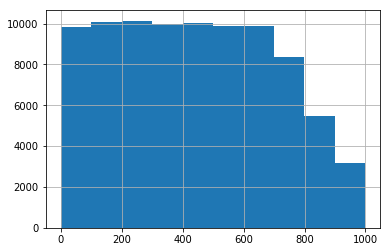

In [94]:
df_vectors['seq_len'].hist()

In [95]:
_t = df_vectors \
    .assign(bin=pd.cut(df_vectors['seq_len'], bins=np.arange(0, 1000, 100))) \
    .assign(acc=lambda x: x.predict == x.bins) \
    .groupby('bin')[['acc']].mean()
_t

,acc
bin,
"(0, 100]",0.507229
"(100, 200]",0.572602
"(200, 300]",0.592717
"(300, 400]",0.600704
"(400, 500]",0.607611
"(500, 600]",0.611607
"(600, 700]",0.617814
"(700, 800]",0.628842
"(800, 900]",0.622411


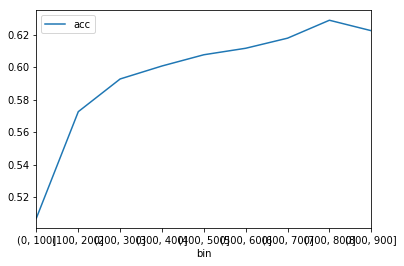

In [96]:
_t.plot()

In [97]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [98]:
pca = PCA(n_components=2)
pca.fit(df_vectors[embedding_columns].values)
np.sum(pca.explained_variance_ratio_)

0.40155715493993416

In [99]:
pca_results = pca.transform(df_vectors[embedding_columns].values)

In [100]:
df_pca = df_vectors.copy()
df_pca['_pca_x'] = pca_results[:, 0]
df_pca['_pca_y'] = pca_results[:, 1]

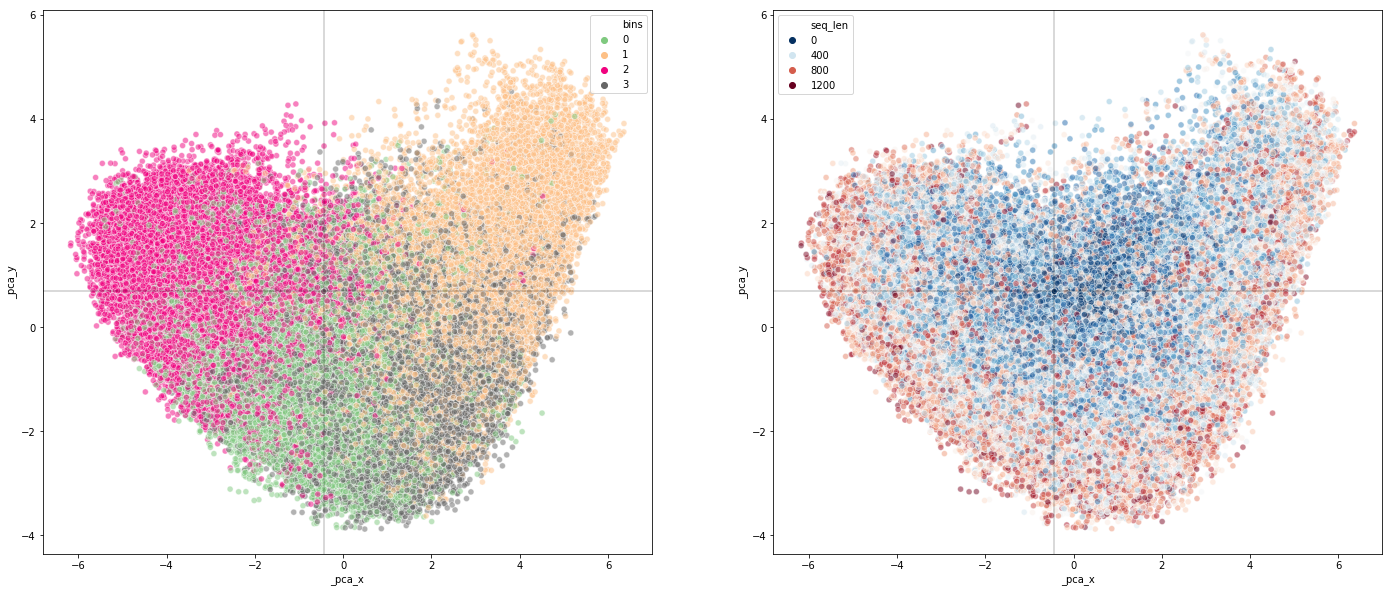

In [107]:
_, axs = plt.subplots(1, 2, figsize=(12 * 2, 10))

cmap = plt.get_cmap('tab10')

sns.scatterplot(
    x='_pca_x', y='_pca_y',
    hue='bins',
    data=df_pca,
    palette='Accent',
    alpha=0.5,
    ax=axs[0],
)
axs[0].axvline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_x'].mean(), alpha=0.2, color='black')
axs[0].axhline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_y'].mean(), alpha=0.2, color='black')

for i in range(0):
    _t = df_pca[lambda x: x.client_id.eq(np.random.choice(df_pca.client_id.unique(), 1)[0])] \
        .sort_values(['seq_len', 'pos_s', 'pos_e'])
    axs[0].plot(_t['_pca_x'], _t['_pca_y'], color=cmap(i), linewidth=3)
    t = axs[0].text(_t.iloc[0]['_pca_x'], _t.iloc[0]['_pca_y'], str(int(_t.iloc[0]['seq_len'])))
    t.set_bbox({'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'white'})
    t = axs[0].text(_t.iloc[-1]['_pca_x'], _t.iloc[-1]['_pca_y'],
                    str(int(_t.iloc[-1]['seq_len'])) + ', ' + str(int(_t.iloc[-1]['bins'])))
    t.set_bbox({'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'white'})

sns.scatterplot(
    x='_pca_x', y='_pca_y',
    hue='seq_len',
    data=df_pca,
    palette='RdBu_r',
    alpha=0.5,
    ax=axs[1],
)
axs[1].axvline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_x'].mean(), alpha=0.2, color='black')
axs[1].axhline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_y'].mean(), alpha=0.2, color='black')

Относительный порядок категорий: 1 - 3 - 0 - 2

In [103]:
if len(df_pca) > 10000:
    df_tsne = df_pca.sample(n=10000).copy()
else:
    df_tsne = df_pca.copy()

In [104]:
tsne = TSNE(n_components=2, verbose=1, n_iter=300)
tsne_results = tsne.fit_transform(df_tsne[embedding_columns].values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.076s...
[t-SNE] Computed neighbors for 10000 samples in 45.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.213556
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.807114
[t-SNE] KL divergence after 300 iterations: 3.456476


In [105]:
df_tsne['_tsne_x'] = tsne_results[:, 0]
df_tsne['_tsne_y'] = tsne_results[:, 1]

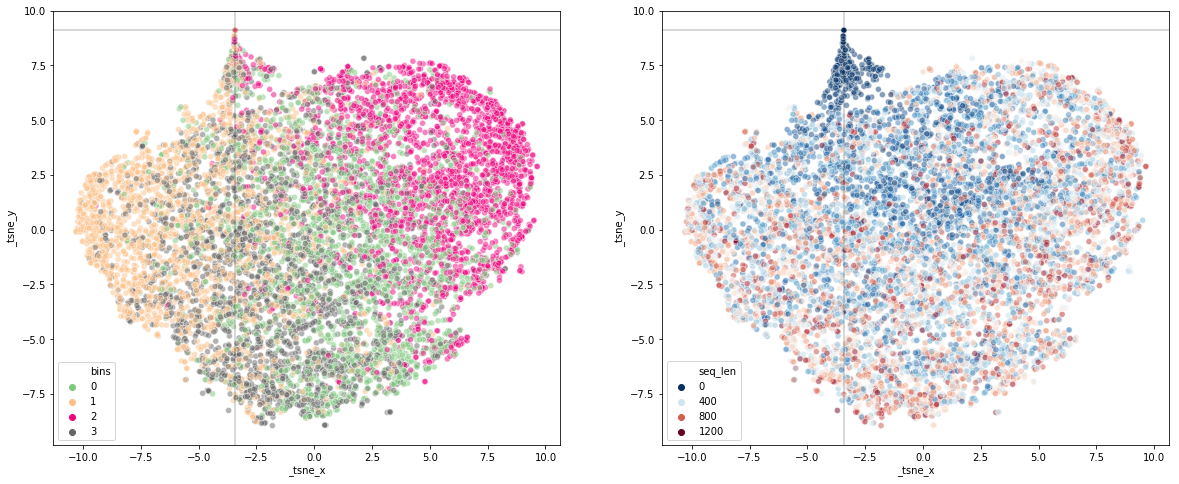

In [106]:
_, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.scatterplot(
    x='_tsne_x', y='_tsne_y',
    hue='bins',
    data=df_tsne,
    palette='Accent',
    alpha=0.5,
    ax=axs[0],
)
axs[0].axvline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_x'].mean(), alpha=0.2, color='black')
axs[0].axhline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_y'].mean(), alpha=0.2, color='black')

sns.scatterplot(
    x='_tsne_x', y='_tsne_y',
    hue='seq_len',
    data=df_tsne,
    palette='RdBu_r',
    alpha=0.5,
    ax=axs[1],
)
axs[1].axvline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_x'].mean(), alpha=0.2, color='black')
axs[1].axhline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_y'].mean(), alpha=0.2, color='black')